# Q3 - Using Builtin RNN Classes

In [16]:
import os, sys, time, string, unicodedata
from copy import deepcopy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
try: os.mkdir("./models")
except FileExistsError: print("Directory Exists... Skipping")

In [4]:
device = torch.device("cpu")
if torch.cuda.is_available: device = torch.device("cuda"); print("Using GPU")

Using GPU


# Download and Preprocess Data

In [5]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

In [6]:
def normalize_sentence(s):
    replacements = [(" ,", ","), (" .", "."), (" '", "'"), 
                    ("\/", "/"), (" ;", ";"), (" :", ":"),
                    (" %", "%"), (u"æ", "ae"), (u"Æ", "AE"), 
                    (u"œ", "oe"), (u"Œ", "OE"), ("-LRB- ", "("), 
                    (" -RRB-", ")"), ("-LRB-", "("), ("-RRB-", ")"),
                    (" n't", "n't"), ("`` ", '"'), ("``", '"'),
                    ("''", '"'), ("` ", "'"), ("$ ", "$"),
                    (" !", "!"), ("\\", ""), (" ?", "?")]
    for to_replace, replacement in replacements:
        s = s.replace(to_replace, replacement)
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters + ' .,;:\'-#!/"=&$?|_'
    ) # https://stackoverflow.com/a/518232/2809427

def get_corpus(path, eol=' '):
    corpus = ""
    with open(path, 'r') as fp:
        for line in fp.readlines():
            soup = line.split()
            tokens = []
            for chunk in soup[2:]:
                if chunk.endswith(')'):
                    tokens.append(chunk.rstrip(')'))
            corpus += normalize_sentence(" ".join(tokens)) + eol
    return corpus

train_corpus = get_corpus("./data/trees/train.txt")
val_corpus = get_corpus("./data/trees/dev.txt")
test_corpus = get_corpus("./data/trees/test.txt")

In [7]:
chars = list(set(train_corpus))
vocab_size = len(chars)
char_to_idx = { ch:i for i,ch in enumerate(chars) }
idx_to_char = { i:ch for i,ch in enumerate(chars) }
print('Train corpus has {} unique chars.'.format(vocab_size))

Train corpus has 67 unique chars.


In [8]:
class SSTDataset(torch.utils.data.Dataset):
    def __init__(self, corpus, seq_len, vocab_size, device):
        self.corpus = corpus
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.device = device
        self.corpus_len = len(self.corpus)
        self.corpus_tensor = torch.tensor([char_to_idx[c] for c in self.corpus]).to(device)
        self.corpus_ohe = torch.zeros(self.corpus_len, self.vocab_size).to(device)
        for i in range(self.corpus_len):
            self.corpus_ohe[i, self.corpus_tensor[i]] = 1
        
        print('corpus is {} characters long, {} unique chars.'.format(
            self.corpus_len, self.vocab_size))
    
    def __len__(self):
        return len(self.corpus) // seq_len
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        start = idx * self.seq_len
        input = self.corpus_ohe[start:start+self.seq_len]
        target = self.corpus_tensor[start+1:start+self.seq_len+1]
        return input, target

In [9]:
# Load datasets
seq_len = 200
train_dataset = SSTDataset(train_corpus, seq_len, vocab_size, device)
val_dataset = SSTDataset(val_corpus, seq_len, vocab_size, device)
test_dataset = SSTDataset(test_corpus, seq_len, vocab_size, device)

corpus is 858720 characters long, 67 unique chars.
corpus is 111526 characters long, 67 unique chars.
corpus is 222395 characters long, 67 unique chars.


# Model Implementation

In [10]:
batch_size = 8

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                batch_size=len(val_dataset), shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                batch_size=len(test_dataset), shuffle=True, drop_last=True)

In [11]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, arch="vanilla"):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.arch = arch
        
        # Select what architecture to use.
        # Since we don't need to provide hidden_0 (or cell_0) tensors
        # for any of the models, we can use this one class for all 3
        if arch == "vanilla":
            self.rnn = nn.RNN(vocab_size, hidden_size, batch_first=True)
        elif arch == "gru":
            self.rnn = nn.GRU(vocab_size, hidden_size, batch_first=True)
        elif arch == "lstm":
            self.rnn = nn.LSTM(vocab_size, hidden_size, batch_first=True)
            
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input):
        hs, h_n = self.rnn(input)
        outputs = self.fc(hs).squeeze()
        outputs = torch.softmax(outputs, axis=-1) # size [batch_size, seq_len, vocab_size]
        return outputs, h_n

## Define Hyperparameters

In [27]:
def eval_model(model, data_iter, criterion):
    """Evaluate our model
    Parameters
    ------
    model - model to be evaluated
    data_iter - data iterator object
    criterion - loss function
    
    Returns
    -------
    accuracy - the dataset accuracy according to (correct / total)
    loss - the dataset loss according to criterion
    """
    acc, n_chars, loss = 0., 0, 0
    with torch.no_grad(): # Don't save computation tree
        for input_batch, target_batch in data_iter:
            outputs, _ = model(input_batch)
            for t in range(target_batch.size(1)): # seq len
                loss += criterion(torch.log(outputs[:, t]), target_batch[:, t])
            loss /= target_batch.size(1) # seq len
            acc += torch.sum(outputs.argmax(axis=-1) == target_batch)
            n_chars += target_batch.numel()
    return acc / n_chars, loss

def show_metrics(model, epoch, best_seen=False):
    """Display the running metrics while training"""
    if best_seen: sys.stdout.write("* Epoch ")
    else: sys.stdout.write("  Epoch ")
    print('{:3.0f} | Train loss {:.5f} | Train acc {:.2%} | Val loss {:.5f} | Val acc {:.2%}'
            .format(epoch, model.train_losses[epoch], model.train_accs[epoch], 
                    model.val_losses[epoch], model.val_accs[epoch]))
    
def train(model, train_iter, val_iter, criterion, model_path, n_epochs=300, init_patience=3):
    """Train our RNN
    Saves the best and final models to file, returns the best model
    Parameters
    ----------
    model - BoV model object
    train_iter - train data iterator
    val_iter - validation data iterator
    criterion - loss function
    model_path - directory to store model checkpoints in
    n_epochs - max number of epochs
    init_patience - max number of consecutively worse epochs to allow
    
    Returns
    -------
    best_model - a model checkpoint from the best observed model
    """
    # Store metrics for the model
    model.train_accs = np.zeros(n_epochs)
    model.train_losses = np.zeros(n_epochs)
    model.val_accs = np.zeros(n_epochs)
    model.val_losses = np.zeros(n_epochs)
    best_model = deepcopy(model)
    
    # 300 epochs is chosen from observing that most models converged between 100-200 epochs.
    epoch, patience = 0, init_patience
    
    model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
    model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)
    show_metrics(model, epoch)
    epoch += 1
    
    while epoch < n_epochs and patience > 0:
        # Prepare model for training.
        model.train()
        for input_batch, target_batch in train_iter:
            model.zero_grad()
            loss = 0
            outputs, h_n = model(input_batch) # Forward pass.
            for t in range(target_batch.size(1)): # seq len
                loss += criterion(torch.log(outputs[:, t]), target_batch[:, t])
            loss /= target_batch.size(1) # seq len
            loss.backward() # Backprop
            optimizer.step() # Update params
        
        model.eval()
        model.train_accs[epoch], model.train_losses[epoch] = eval_model(model, train_iter, criterion)
        model.val_accs[epoch], model.val_losses[epoch] = eval_model(model, val_iter, criterion)

        # Save the best model for later
        if epoch < 2 or model.val_losses[epoch] < model.val_losses[:epoch].min():
            best_model = deepcopy(model)
            best_model.train_accs = model.train_accs[:epoch+1]
            best_model.train_losses = model.train_losses[:epoch+1]
            best_model.val_accs = model.val_accs[:epoch+1]
            best_model.val_losses = model.val_losses[:epoch+1]
            torch.save(best_model, os.path.join(model_path, "best_model.torchmodel"))
            show_metrics(model, epoch, best_seen=True)
        else: show_metrics(model, epoch)
            
        # Check for convergence
        if model.val_losses[epoch] > model.val_losses[epoch - 1]: patience -= 1
        else: patience = init_patience
        
        epoch += 1
    
    # Remove unused epochs
    model.train_accs = model.train_accs[:epoch]
    model.train_losses = model.train_losses[:epoch]
    model.val_accs = model.val_accs[:epoch]
    model.val_losses = model.val_losses[:epoch]
    torch.save(model, os.path.join(model_path, "final_model.torchmodel"))
    
    print("""*********** DONE **********\n 
        Validation accuracy at best epoch {} was {:.2%}. Returning that model."""
        .format(model.val_losses.argmin(), model.val_accs[model.val_losses.argmin()]))
    return best_model

In [28]:
# hyperparameters
hidden_size = 250 # size of hidden layer
lr = 1e-3
n_epochs = 100
init_patience = 5
arch = "gru"
PATH = "./models/{}-{}".format(arch, time.strftime("%m-%d-%H%M", time.gmtime()))

rnn = RNN(vocab_size, hidden_size, arch).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(rnn.parameters(), lr=lr)
losses, train_accs, val_accs = np.zeros(n_epochs), np.zeros(n_epochs), np.zeros(n_epochs)
epoch, patience = 0, init_patience

## Train Model

In [29]:
model_path = "./models/{}-{}".format("BoV", time.strftime("%m-%d-%H%M", time.gmtime()))
try: os.mkdir(model_path)
except FileExistsError: print("Directory Exists... Skipping")
print("Model folder: {}".format(model_path))

best_model = train(rnn, train_loader, val_loader, criterion, model_path, n_epochs=200, init_patience=10)
final_model = deepcopy(rnn)

Directory Exists... Skipping
Model folder: ./models/BoV-12-14-2137
  Epoch   0 | Train loss 4.22291 | Train acc 0.31% | Val loss 4.20231 | Val acc 0.35%
* Epoch   1 | Train loss 2.21707 | Train acc 35.95% | Val loss 2.22422 | Val acc 35.95%
* Epoch   2 | Train loss 1.98723 | Train acc 41.72% | Val loss 2.00388 | Val acc 41.57%
* Epoch   3 | Train loss 1.89734 | Train acc 45.84% | Val loss 1.84368 | Val acc 45.71%
* Epoch   4 | Train loss 1.79706 | Train acc 49.53% | Val loss 1.73040 | Val acc 49.27%
* Epoch   5 | Train loss 1.67091 | Train acc 51.87% | Val loss 1.65666 | Val acc 51.42%
* Epoch   6 | Train loss 1.56950 | Train acc 53.50% | Val loss 1.60469 | Val acc 52.88%
* Epoch   7 | Train loss 1.52474 | Train acc 54.78% | Val loss 1.56955 | Val acc 53.83%
* Epoch   8 | Train loss 1.52539 | Train acc 56.05% | Val loss 1.53692 | Val acc 54.99%
* Epoch   9 | Train loss 1.44023 | Train acc 56.75% | Val loss 1.51630 | Val acc 55.39%
* Epoch  10 | Train loss 1.45974 | Train acc 57.51% | V

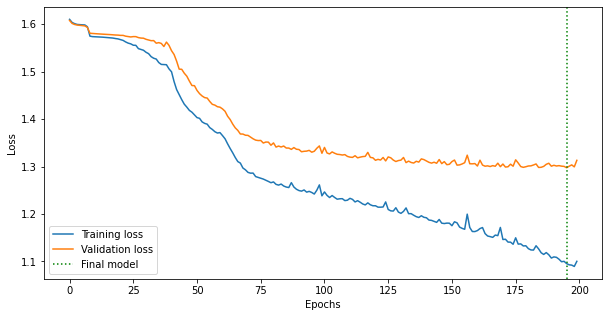

In [22]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_losses, label="Training loss")
plt.plot(final_model.val_losses, label="Validation loss")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_path, "losses.png"))

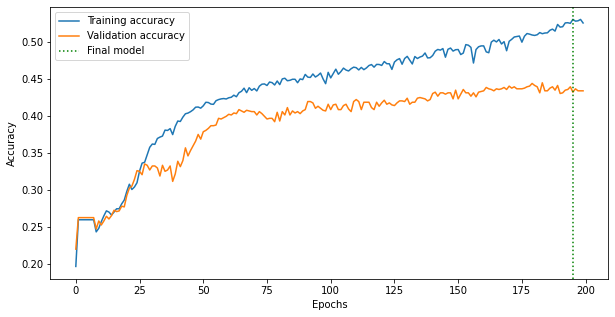

In [23]:
plt.figure(figsize=(10,5))
plt.plot(final_model.train_accs, label="Training accuracy")
plt.plot(final_model.val_accs, label="Validation accuracy")
plt.axvline(final_model.val_losses.argmin(), linestyle='dotted', color='g',label='Final model')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_path, "accs.png"))

## Test Accuracy

In [46]:
print("Test accuracy: {:.2%}".format(eval_model(rnn, test_loader, criterion)[0]))

Test accuracy: 57.87%


# Generate Sequences

In [45]:
def predict_one(model, s, argmax=False):
    batch_size = 1
    corpus_tensor = torch.tensor([char_to_idx[c] for c in s])
    corpus_ohe = torch.zeros(batch_size, corpus_tensor.size(0), vocab_size).to(device)
    for i in range(corpus_tensor.size(0)):
        corpus_ohe[0, i, corpus_tensor[i]] = 1
    
    with torch.no_grad():
        outputs, _ = model(corpus_ohe)
        last_prob = outputs[-1]
        argmax_idx = last_prob.argmax().item()
        sample_idx = last_prob.multinomial(num_samples=1, replacement=True).item()
        
        if argmax:
            pred_char = idx_to_char[argmax_idx]
        else:
            pred_char = idx_to_char[sample_idx]
    return pred_char

def predict_n_from_seed(n, seed, model):
    output = seed
    for _ in range(n - len(output)):
        c = predict_one(model, output)
        output += c
    return output

predict_n_from_seed(200, '"To be or not to be', rnn)

'"To be or not to be darks a fall picked phonanced and pitched off another and mediocre junk beganed details he was taw look a half-down the bentament with a few of the issible defeatingly, indulgently'